# Séance 1 :  Deep Learning - Introduction à Pytorch 

Les notebooks sont très largement inspirés des cours de **N. Baskiotis et B. Piwowarski**. Ils peuvent être complétés efficacement par les tutoriels *officiels* présents sur le site de pytorch:
https://pytorch.org/tutorials/

Au niveau de la configuration, toutes les installations doivent fonctionner sur Linux et Mac. Pour windows, ça peut marcher avec Anaconda à jour... Mais il est difficile de récupérer les problèmes.

* Aide à la configuration des machines: [lien](https://dac.lip6.fr/master/environnement-deep/)
* Alternative 1 à Windows: installer Ubuntu sous Windows:  [Ubuntu WSL](https://ubuntu.com/wsl)
* Alternative 2: travailler sur Google Colab (il faut un compte gmail + prendre le temps de comprendre comment accéder à des fichers) [Colab](https://colab.research.google.com)

In [1]:
import torch
print("La version de torch est : ",torch.__version__)
print("Le calcul GPU est disponible ? ", torch.cuda.is_available())

# pour les possesseurs de mac M1 avec la dernière version de pytorch:
print("Le calcul GPU est disponible ? ", torch.backends.mps.is_available())

# on activera ces options plus tard, au niveau des modules et des données

import matplotlib.pyplot as plt
import numpy as np
import sklearn

La version de torch est :  2.2.2+cpu
Le calcul GPU est disponible ?  False
Le calcul GPU est disponible ?  False


# A. Autograd et graphe de calcul
Un élément central de pytorch est le graphe de calcul : lors du calcul d'une variable, l'ensemble des opérations qui ont servies au calcul sont stockées sous la forme d'un graphe acyclique, dit de *calcul*. Les noeuds internes du graphe représentent les opérations, le noeud terminal le résultat et les racines les variables d'entrées. Ce graphe sert en particulier à calculer les dérivées partielles de la sortie par rapport aux variables d'entrées - en utilisant les règles de dérivations chainées des fonctions composées. 
Pour cela, toutes les fonctions disponibles dans pytorch comportent un mécanisme, appelé *autograd* (automatique differentiation), qui permet de calculer les dérivées partielles des opérations. 

## A.1. Différenciation automatique
(De manière simplifiée, pour les détails cf [la documentation](https://pytorch.org/docs/stable/notes/extending.html))


 La méthode **backward** d'un tenseur permet de rétro-propager le calcul du gradient sur toutes les variables qui ont servies à son calcul.

La valeur du gradient pour chaque dérivée partielle se trouve dans l'attribut **grad** de la variable concernée. 

Comme c'est un mécanisme lourd, l'autograd n'est pas activé par défaut pour une variable. Afin de l'activer, il faut mettre le flag **requires_grad** de cette variable à vrai. Dès lors, tout calcul qui utilise cette variable sera enregistré dans le graphe de calcul et le gradient sera disponible.


Si vous n'êtes pas à l'aise, commencez par calculer le gradient de :
$$ z = 2*a + b $$
par rapport aux deux variables $a$ et $b$: 
$$ \frac{\partial z}{\partial a}, \qquad \frac{\partial z}{\partial b}$$
Noter que l'architecture ne fait pas de calcul symbolique: toutes les variables ont des valeurs numériques et les gradients sont évalués en un point.

Exemple : 

In [2]:
a = torch.tensor(1.)
# Par défaut, requires_grad est à False
print("Graphe de calcul ? ",a.requires_grad)
# On peut demander à ce que le graphe de calcul soit retenu
a.requires_grad = True 
# Ou lors de la création du tenseur directement
b = torch.tensor(2.,requires_grad=True)
z = 2*a + b
# Calcul des dérivées partielles par rapport à z
z.backward()
print("Dérivée de z/a : ", a.grad.item()," z/b :", b.grad.item())


Graphe de calcul ?  False
Dérivée de z/a :  2.0  z/b : 1.0


In [3]:
# Si on a oublié de demander le graphe de calcul :
a, b = torch.tensor(1.),torch.tensor(2.)
z = 2*a+b
try: # on sait que ça va provoquer une erreur
  z.backward()
except Exception as e: # erreur => simple message
  print("Erreur : ", e)

Erreur :  element 0 of tensors does not require grad and does not have a grad_fn


## A.2.  <span style="color:red">     Exo : </span> Utilisation de backward     
* Implémentez (en une ligne) la fonction de coût aux moindres carrés $MSE(\hat{y},y)=\frac{1}{2N} \sum_{i=1}^N\|\hat{y_i}-y_i\|^2$ où $\hat{y},y$ sont deux matrices de taille $N\times d$, et $y_i,\hat{y_i}$ les $i$-èmes vecteurs lignes des matrices.
* Engendrez **y,yhat** deux matrices aléatoires de taille $(1,5)$.
* Calculez **MSE(y,yhat)**
* Calculez à la main le gradient de **MSE** par rapport à **y**, **yhat**
* Calculez grâce à pytorch le gradient de **MSE** par rapport à **y** et **yhat** et vérifier le résultat.
* Appelez une deuxième fois **MSE** sur les mêmes vecteurs et la méthode **backward**. Qu'observez vous pour le gradient ? Comment l'expliquez vous ?

In [4]:
def MSE(yhat,y): # sur des vecteurs
    # Compléter la fonction 
    ##  TODO 

    return (1/(2*yhat.size(0)))*torch.sum(torch.abs(yhat-y)**2)



In [5]:
# définir des éléments à rapprocher au sens de la MSE précédente

#y    = torch.tensor([1., 2., 1.], dtype = torch.float,requires_grad=True)
#yhat = torch.tensor([0., 0., 0.], dtype = torch.float,requires_grad=True)
# ou une variante
y    = torch.randn(1,5,requires_grad=True)
yhat = torch.randn(1,5,requires_grad=True)
mse = MSE(yhat,y)
print("MSE :" ,mse)
print(yhat)

MSE : tensor(2.3232, grad_fn=<MulBackward0>)
tensor([[ 0.3714, -1.7816,  0.4425, -1.0952, -0.2862]], requires_grad=True)


In [6]:

# 1. retro-propager l'erreur
# 2. afficher le gradient sur les deux vecteurs et comprendre ce qui se passe
# 3. faire une itération supplémentaire de gradient et afficher de nouveau

mse.backward()

print(y.grad)
print(yhat.grad)
##  TODO 

tensor([[ 0.6682,  1.8384,  0.1198,  0.6856, -0.5793]])
tensor([[-0.6682, -1.8384, -0.1198, -0.6856,  0.5793]])


## Pour une compréhension du gradient en mode graphique

Soit les points `A` et `B` de coordonnées respective $(1, 2)$ et $(4, 4)$. Si je construis une fonction qui minimise la distance entre $A$ et $B$ et que je calcule les gradients, j'obtiens des **directions** qu permettent de rapprocher les points:

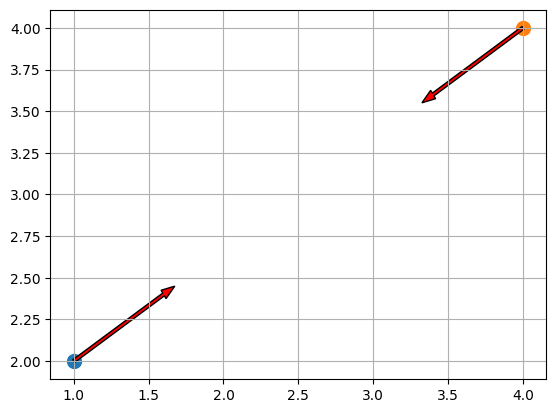

In [7]:
A = torch.tensor([1.,2], requires_grad=True)
B = torch.tensor([4.,4], requires_grad=True)

C = ((A-B)**2).sum()
C.backward()

eps = 0.1
with torch.no_grad():
    # en version graphique:
    plt.figure()
    plt.grid()
    plt.scatter(A[0],A[1], s=100)
    plt.scatter(B[0],B[1], s=100)
    plt.arrow(A[0],A[1],-eps*A.grad[0],-eps*A.grad[1], shape='full', width=0.02, facecolor='r')
    plt.arrow(B[0],B[1],-eps*B.grad[0],-eps*B.grad[1], shape='full', width=0.02, facecolor='r')

## Retour sur la régression polynomiale

Soit un ensemble de points de $\mathbb R^2$, $\{A, B, C, D\}$. Construire la fonction $y=a x^4 + b x^3, + c x^2 + d x + e$ passant par tous les points.

tensor([[1., 2.],
        [2., 3.],
        [3., 0.],
        [4., 2.]])


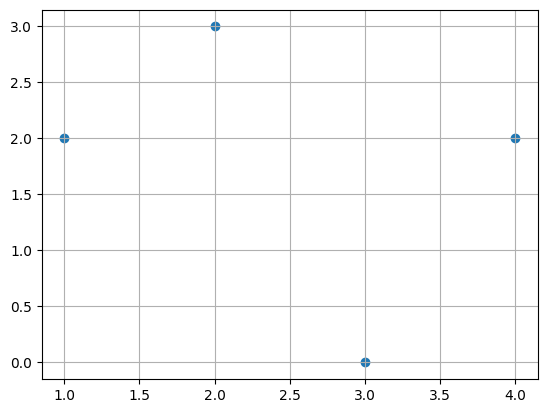

In [8]:
A = torch.tensor([[1.,2]]) # tensor 2D pour pouvoir les concaténer
B = torch.tensor([[2.,3]])
C = torch.tensor([[3.,0]])
D = torch.tensor([[4.,2]])

# 1. Regrouper les points dans X
# Faut-il activer le gradient sur ces points?

X = torch.cat((A, B, C, D), dim=0)
print(X)

# validation
with torch.no_grad():
    plt.figure()
    plt.grid()
    plt.scatter(X[:,0], X[:,1])


In [18]:
# 2. Construire la fonction de prediction et la fonction de cout
# a) initialiser les coefficients a, b, c, d, e aléatoirement (randn)
#       - faut-il activer le gradient sur ces coeffcients?
# b) définir yhat = 

torch.manual_seed(42)

a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
c = torch.randn(1, requires_grad=True)
d = torch.randn(1, requires_grad=True)
e = torch.randn(1, requires_grad=True)

#  TODO 

yhat = a* X[:,0]**4 + b * X[:,0] **3 + c *  X[:,0] **2 + d* X[:,0] + e 

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True) tensor([0.2345], requires_grad=True) tensor([0.2303], requires_grad=True) tensor([-1.1229], requires_grad=True)


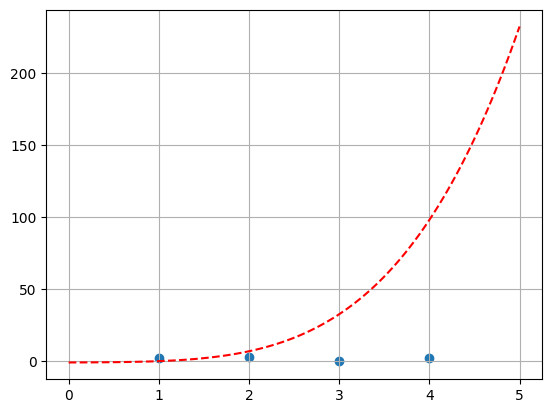

In [19]:
# 3. Affichage de ce régresseur (qui est aléatoire pour le moment)

N = 100 # 100 points
x = torch.linspace(0,5,N)
y = a * x**4 + b * x**3 + c * x**2 + d *x +e

with torch.no_grad():   
    print(a, b, c, d, e)
    plt.figure()
    plt.grid()
    plt.scatter(X[:,0], X[:,1])
    plt.plot(x,y, 'r--')


In [14]:
# optimisation
niter = 30000
eps = 1e-3

for i in range(niter):
    # définition de l'estimateur yhat et du cout: cost
    yhat = a* X[:,0] **4 + b * X[:,0] **3 + c *  X[:,0] **2 + d* X[:,0] + e 

    cost = MSE(yhat, X[:,1])

    cost.backward()
    # mise à jour des paramètres
    with torch.no_grad():
        a -=  0.005* eps * a.grad
        b -=  0.05  * eps * b.grad
        c -=  2 * eps * c.grad
        d -=  10 * eps * d.grad
        e -=  10 * eps * e.grad
        
    # penser à remettre les gradients à 0
    a.grad.zero_()
    b.grad.zero_()
    c.grad.zero_()
    d.grad.zero_()
    e.grad.zero_()
    

tensor([0.1708], requires_grad=True) tensor([-0.5361], requires_grad=True) tensor([-2.5020], requires_grad=True) tensor([9.1739], requires_grad=True) tensor([-4.1253], requires_grad=True)


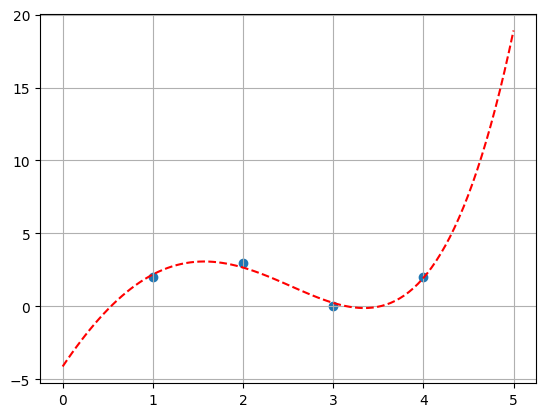

In [15]:
# affichage du résultat
y = a * x**4 + b * x**3 + c * x**2 + d *x +e

with torch.no_grad():   
    print(a, b, c, d, e )
    plt.figure()
    plt.grid()
    plt.scatter(X[:,0], X[:,1])
    plt.plot(x,y, 'r--')

tensor([[ 1.,  1.,  1.,  1.],
        [ 8.,  4.,  2.,  1.],
        [27.,  9.,  3.,  1.],
        [64., 16.,  4.,  1.]])
tensor([1.4996]) tensor([-10.9971]) tensor([23.4934]) tensor([-11.9957]) tensor([-1.1229], requires_grad=True)


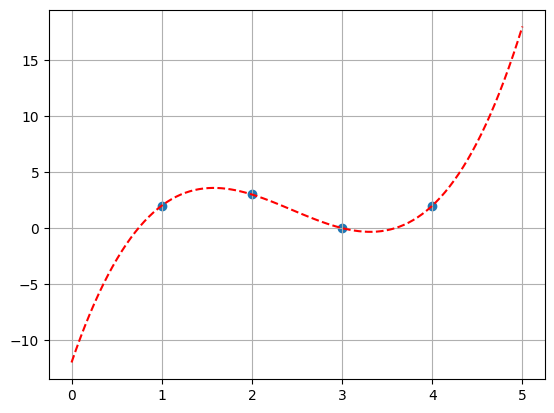

In [20]:
# Solution analytique
# comparons les performances et le temps de calcul
# SGD = le 4x4 de l'optimisation... Pas forcément la meilleure solution !

X0 = X[:,0].view(-1,1)
X1 = X[:,1].view(-1,1)
X2 = torch.cat(( X0**3, X0**2, X0, torch.ones(X0.size())), dim=1)
print(X2)
w = torch.inverse(X2.T@X2) @ X2.T @ X1

a=w[0]
b=w[1]
c=w[2]
d=w[3]
# e=w[4]

# affichage du résultat
y = a * x**3 + b * x**2 + c * x + d 

with torch.no_grad():   
    print(a, b, c, d, e)
    plt.figure()
    plt.grid()
    plt.scatter(X[:,0], X[:,1])
    plt.plot(x,y, 'r--')


## A.3. <span style="color:red">  Exo : </span>  Régression linéaire en pytorch 

* Définissez la fonction **flineaire(x,w,b)** fonction linéaire qui calcule:
 $f(x,w,b)=x.w^t+b$  avec $x\in \mathbb{R}^{{n\times d}},~w\in\mathbb{R}^{1,d}, b\in \mathbb{R}$
* Complétez le code ci-dessous pour réaliser une descente de gradient et apprendre les paramètres optimaux de la regression linéaire : $$w^∗,b^∗=\text{argmin}_{w,b}\frac{1}{N} \sum_{i=1}^N \|f(x^i,w,b)-y^i\|^2$$

Pour tester votre code, utilisez le jeu de données très classique *housing*, le prix des loyers à housing en fonction de caractéristiques socio-économiques des quartiers. Le code ci-dessous permet de les charger.



<span style="color:red"> ATTENTION ! </span> pour la mise-à-jour des paramètres, <span style="color:red">vous ne pouvez pas faire directement</span> 
$$w = w-\epsilon*gradient$$ 
<span style="color:blue">(pourquoi ?)</span> 

Vous devez passer par w.data qui permet de ne pas enregistrer les opérations dans le graphe de calcul (ou utiliser la méthode ```.detach()``` d'une variable qui permet de créer une copie détachée du graphe de calcul). 

Note: il est aussi possible de faire:

```
with torch.no_grad():
    w -= eps*gradient
```

* Désactivation temporaire du graph de calcul, on manipule les tensors comme des variables classiques
* ATTENTION à faire des ```-=``` ou ```+=``` => Si vous construisez un nouveau tenseur, il ne se reconnectera pas au graphe de calcul!

L'algorithme doit converger avec la valeur de epsilon fixée; si ce n'est pas le cas, il y a une erreur (la plupart du temps au niveau du calcul du coût).


In [21]:
def flineaire(x,w,b):
    # Produit scalaire + biais

    return x @ torch.transpose(w) + b

In [ ]:
# Est ce que ça marche sur une taille de problème arbitraire de 3?
w = torch.randn(1, 3, requires_grad=True)
x = torch.tensor([1., 1., 1.])
b = torch.tensor(0.5)

print(flineaire(x, w, b))

TypeError: transpose() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (Tensor input, int dim0, int dim1)
 * (Tensor input, name dim0, name dim1)


In [24]:

## Chargement des données housing (depuis sklearn) et transformation en tensor.
# from sklearn.datasets import load_housing # => removed
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
housing = fetch_california_housing(data_home="./data/") ## chargement des données

# séparation des ensembles de données
X_train, X_test, y_train, y_test = train_test_split( housing['data'], housing['target'],
                                                                 test_size=0.33, random_state=42)

housing_x = torch.tensor(X_train ,dtype=torch.float) # penser à typer les données pour éliminer les incertitudes
housing_y = torch.tensor(y_train,dtype=torch.float)
housing_xT = torch.tensor(X_test,dtype=torch.float) # penser à typer les données pour éliminer les incertitudes
housing_yT = torch.tensor(y_test,dtype=torch.float)

print("Nombre d'exemples : ",housing_x.size(0), "Dimension : ",housing_x.size(1))
print("Nom des attributs : ", ", ".join(housing['feature_names']))

print(housing_x[:5])


c:\ProgramData\Anaconda3\envs\torch2025\Lib\site-packages\sklearn\datasets\_base.py:1518: UserWarning: Retry downloading from url: https://ndownloader.figshare.com/files/5976036
  warnings.warn(f"Retry downloading from url: {remote.url}")


Nombre d'exemples :  13828 Dimension :  8
Nom des attributs :  MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude
tensor([[ 9.8090e-01,  1.9000e+01,  3.1877e+00,  1.1300e+00,  7.2600e+02,
          2.6209e+00,  3.3980e+01, -1.1828e+02],
        [ 4.2232e+00,  3.3000e+01,  6.1897e+00,  1.0867e+00,  1.0150e+03,
          2.3770e+00,  3.7460e+01, -1.2223e+02],
        [ 3.5488e+00,  4.2000e+01,  4.8216e+00,  1.0954e+00,  1.0440e+03,
          4.3320e+00,  3.3790e+01, -1.1826e+02],
        [ 1.6469e+00,  2.4000e+01,  4.2742e+00,  1.0484e+00,  1.6860e+03,
          4.5323e+00,  3.5870e+01, -1.1926e+02],
        [ 3.9909e+00,  1.4000e+01,  4.6083e+00,  1.0894e+00,  2.7380e+03,
          2.4711e+00,  3.7540e+01, -1.2196e+02]])


In [ ]:

EPOCHS = 5000
EPS = 1e-7 # que se passe-t-il lorsqu'on joue avec EPS?

# initialisation aléatoire de w et b
w = torch.randn(1,housing_x.size(1),requires_grad=True)
b = torch.randn(1,1,requires_grad=True)
loss_h = [] # sauvegarde des valeurs de loss (pas si trivial!)

# boucle de descente de gradient
for i in range(EPOCHS):
    pass
    ## SOLUTION 1: Penser à aller chercher w.data (et sa contrepartie dans le gradient)
    # 1. Construire la loss (+stocker la valeur dans loss_h)
    # 2. Retro-propager
    # 3. MAJ des paramètres
    # 4. Penser à remettre le gradient à 0 (cf exo précédent)
    ##  TODO 

    

In [ ]:
# une seconde version du même code avec l'environnement torch.no_grad()
# attention, dans ce cas, le += est obligatoire
# code identique (juste changer les 2 lignes de MAJ)

EPOCHS = 5000
EPS = 1e-7
#initialisation aléatoire de w et b
w = torch.randn(1,housing_x.size(1),requires_grad=True)
b =  torch.randn(1,1,requires_grad=True)
loss_h = [] # sauvegarde des valeurs de loss (pas si trivial!)
for i in range(EPOCHS):
    pass
    ## SOLUTION 2: avec torch.no_grad() [toutes les lignes sont identiques, sauf les 2 lignes de MAJ des paramètres]
    ##  TODO 

In [ ]:
# affichage de l'optimisation
plt.figure()
plt.plot(loss_h)
plt.xlabel("epochs")
plt.ylabel("mse loss")


## Optimiseur 
La descente de gradient représente en fait un code standard puisque les dérivées sont calculées automatiquement et que les variables sont idéntifiées.
Pytorch inclut une classe très utile pour la descente de gradient, [torch.optim](https://pytorch.org/docs/stable/optim.html), qui permet :
* d'économiser quelques lignes de codes
* d'automatiser la mise-à-jour des paramètres 
* d'abstraire le type de descente de gradient utilisé (sgd,adam, rmsprop, ...)

Une liste de paramètres à optimiser est passée à l'optimiseur lors de l'initialisation. La méthode **zero_grad()** permet de remettre le gradient à zéro et la méthode **step()** permet de faire une mise-à-jour des paramètres.

Un exemple de code  utilisant l'optimiseur est donné ci-dessous. Testez et comparez les résultats.


In [ ]:
Xdim = housing_x.size(1)

w = torch.randn(1,Xdim,dtype=torch.float,requires_grad=True)
b = torch.randn(1,dtype=torch.float,requires_grad=True)

## on optimise selon w et b.  lr est le pas du gradient
optim = torch.optim.SGD(params=[w,b],lr=EPS) 
for i in range(EPOCHS):
  loss = MSE(flineaire(housing_x,w,b).view(-1,1),housing_y.view(-1,1))
  optim.zero_grad()
  loss.backward()
  optim.step()  
  if i % 100==0:  print(f"iteration : {i}, loss : {loss}")


## Mise en perspective

Les résultats obtenus sont-ils bons??

- comparaison avec un modèle naif = prédiction de la moyenne
- comparaison avec un modèle linéaire
- comparaison avec une forêt aléatoire

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# modele moyen
err = mean_squared_error(y_test, y_test.mean()*np.ones(y_test.shape))
print("err / moyenne : ", err)

# modèle linéaire
mod = LinearRegression()
mod.fit(X_train,y_train)
yhat = mod.predict(X_test)
err = mean_squared_error(y_test, yhat)
print("err / lin : ", err)

# gradient boosting
mod = GradientBoostingRegressor()
mod.fit(X_train,y_train)
yhat = mod.predict(X_test)
err = mean_squared_error(y_test, yhat)
print("err / grad boost : ", err)

Quelques propositions rapides pour être moins ridicule !

In [ ]:
Xdim = housing_x.size(1)

w = torch.randn(1,Xdim,dtype=torch.float,requires_grad=True)
b = torch.randn(1,dtype=torch.float,requires_grad=True)
with torch.no_grad(): # adoucir l'initialisation => optimisation plus facile
  w*=0.1
  b*=0.1

## on optimise selon w et b.  lr est le pas du gradient
# optim = torch.optim.SGD(params=[w,b],lr=EPS) 
optim = torch.optim.Adam(params=[w,b],lr=1e-3) # un peu plus efficace
for i in range(EPOCHS):
  loss = MSE(flineaire(housing_x,w,b).view(-1,1),housing_y.view(-1,1))
  optim.zero_grad()
  loss.backward()
  optim.step()  
  if i % 100==0:  print(f"iteration : {i}, loss : {loss}")

print("Résultat en test : ", MSE(flineaire(housing_xT,w,b).view(-1,1),housing_yT.view(-1,1)).item())


# Construction du sujet à partir de la correction

In [ ]:
###  TODO )"," TODO ",\
    txt, flags=re.DOTALL))
f2.close()

### </CORRECTION> ###